<a href="https://colab.research.google.com/github/raduga256/fine-tuning-classifiers/blob/main/RandomFClassifier_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

my aim was not to build a robust classifier, rather I wanted to show the practicality of optimizing a classifier for sensitivity. In figure A below, the goal is to move the decision threshold to the left. This minimizes false negatives, which are especially troublesome in the dataset chosen for this post. It contains features from images of 357 benign and 212 malignant breast biopsies. A false negative sample equates to missing a diagnosis of a malignant tumor. 

With scikit-learn, tuning a classifier for recall can be achieved in (at least) two main steps.
Using GridSearchCV to tune your model by searching for the best hyperparameters and keeping the classifier with the highest recall score.
Adjust the decision threshold using the precision-recall curve and the roc curve, which is a more involved method..

In [28]:
# Start by loading the necessary libraries and the data.
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve,plot_roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/breast_cancer_dataset.csv")
df2 = df

In [4]:
df2.sample(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
189,874839,B,12.30,15.90,78.83,463.7,0.08080,0.07253,0.038440,0.016540,0.1667,0.05474,0.2382,0.8355,1.687,18.320,0.005996,0.022120,0.021170,0.006433,0.02025,0.001725,13.350,19.59,86.65,546.7,0.10960,0.16500,0.14230,0.04815,0.2482,0.06306,NaN
190,874858,M,14.22,23.12,94.37,609.9,0.10750,0.24130,0.198100,0.066180,0.2384,0.07542,0.2860,2.1100,2.112,31.720,0.007970,0.135400,0.116600,0.016660,0.05113,0.011720,15.740,37.18,106.40,762.4,0.15330,0.93270,0.84880,0.17720,0.5166,0.14460,NaN
386,902975,B,12.21,14.09,78.78,462.0,0.08108,0.07823,0.068390,0.025340,0.1646,0.06154,0.2666,0.8309,2.097,19.960,0.004405,0.030260,0.043440,0.010870,0.01921,0.004622,13.130,19.29,87.65,529.9,0.10260,0.24310,0.30760,0.09140,0.2677,0.08824,NaN
89,861598,B,14.64,15.24,95.77,651.9,0.11320,0.13390,0.099660,0.070640,0.2116,0.06346,0.5115,0.7372,3.814,42.760,0.005508,0.044120,0.044360,0.016230,0.02427,0.004841,16.340,18.24,109.40,803.6,0.12770,0.30890,0.26040,0.13970,0.3151,0.08473,NaN
307,89346,B,9.00,14.40,56.36,246.3,0.07005,0.03116,0.003681,0.003472,0.1788,0.06833,0.1746,1.3050,1.144,9.789,0.007389,0.004883,0.003681,0.003472,0.02701,0.002153,9.699,20.07,60.90,285.5,0.09861,0.05232,0.01472,0.01389,0.2991,0.07804,NaN


The class distribution can be found by counting the diagnosis column. B for benign and M for malignant.

Convert the class labels and split the data into training and test sets. train_test_split with stratify=True results in consistent class distribution between training and test sets:

In [5]:
# by default majority class(benign) will be negative
lb = LabelBinarizer()
df['diagnosis'] = lb.fit_transform(df['diagnosis'].values)
targets = df['diagnosis']

df.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1, inplace=True)

#train test split
X_train, X_test, y_train, y_test = train_test_split(df, targets, stratify=targets, random_state=42)

In [6]:
# show the distribution
print('y_train class distribution')
print(y_train.value_counts(normalize=True))

print('y_test class distribution')
print(y_test.value_counts(normalize=True))


y_train class distribution
0    0.626761
1    0.373239
Name: diagnosis, dtype: float64
y_test class distribution
0    0.629371
1    0.370629
Name: diagnosis, dtype: float64


Now that the data has been prepared, the classifier can be built.

## First strategy: Optimize for sensitivity using GridSearchCV with the scoring argument.

First build a generic classifier and setup a parameter grid; random forests have many tunable parameters, which make it suitable for GridSearchCV. The scorers dictionary can be used as the scoring argument in GridSearchCV. When multiple scores are passed, GridSearchCV.cv_results_ will return scoring metrics for each of the score types provided.

In [7]:
clf = RandomForestClassifier()

param_grid = {
    'min_samples_split': [3, 5 , 10],
    'n_estimators': [100, 300],
    'max_depth':[3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

The function below uses GridSearchCV to fit several classifiers according to the combinations of parameters in the param_grid. The scores from scorers are recorded and the best model (as scored by the refit argument) will be selected and "refit" to the full training data for downstream use. This also makes predictions on the held out X_test and prints the confusion matrix to show performance.
The point of the wrapper function is to quickly reuse the code to fit the best classifier according to the type of scoring metric chosen. First, try precision_score, which should limit the number of false positives. This isn't well-suited for the goal of maxium sensitivity, but allows us to quickly show the difference between a classifier optimized for precision_score and one optimized for recall_score.

In [8]:
def grid_search_wrapper(refit_score='precision_score'):
  """
  fits a GridSearchCV classifier using refit_score for optimisation
  prints classifier performance metrics
  """
  skf = StratifiedKFold(n_splits=10)
  grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score, cv=skf, return_train_score=True, n_jobs=-1)
  grid_search.fit(X_train.values, y_train.values)

  #make the predictions
  y_pred = grid_search.predict(X_test.values)

  print('Best params for {}'.format(refit_score))
  print(grid_search.best_params_)

  # confusion matrix on the test data
  print('\nConfusion matrix of Random Forest optimised for {} on the test data:'.format(refit_score))
  print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['pred_neg', 'pred_pos'], index=['neg','pos']))

  return grid_search

In [9]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'max_depth': 5, 'max_features': 10, 'min_samples_split': 5, 'n_estimators': 300}

Confusion matrix of Random Forest optimised for precision_score on the test data:
     pred_neg  pred_pos
neg        90         0
pos         5        48


The precision, recall, and accuracy scores for every combination of the parameters in param_grid are stored in cv_results_. Here, a pandas DataFrame helps visualize the scores and parameters for each classifier iteration. This is included to show that although accuracy may be relatively consistent across classifiers, it’s obvious that precision and recall have a trade-off. Sorting by precision, the best scoring model should be the first record. This can be checked by looking at the parameters of the first record and comparing them to grid_search.best_params_ above.

In [10]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
39,0.969,0.931,0.962,5,10,5,300
73,0.969,0.937,0.965,25,3,3,300
49,0.968,0.931,0.962,15,3,3,300
84,0.965,0.943,0.965,25,10,3,100
90,0.965,0.937,0.962,25,20,3,100


That classifier was optimized for precision. For comparison, to show how GridSearchCV selects the best classifier, the function call below returns a classifier optimized for recall. The grid might be similar to the grid above, the only difference is that the classifer with the highest recall will be refit. This will be the most desirable metric in the cancer diagnosis classification problem, there should be less false negatives on the test set confusion matrix.

In [11]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'max_depth': 3, 'max_features': 5, 'min_samples_split': 10, 'n_estimators': 300}

Confusion matrix of Random Forest optimised for recall_score on the test data:
     pred_neg  pred_pos
neg        90         0
pos         7        46


Generating the results table again, only this time it the best scores will be recall.

In [12]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)

results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
42,0.970,0.925,0.960,5,20,3,100
0,0.969,0.918,0.958,3,3,3,100
75,0.964,0.937,0.962,25,3,5,300
24,0.964,0.931,0.960,5,3,3,100
68,0.964,0.937,0.962,15,20,5,100


The first strategy doesn’t yield impressive results for recall_score, it doesn’t significantly reduce (if at all) the number of false negatives compared to the classifier optimized for precision_score. Ideally, when designing a cancer diagnosis test, the classifier should strive as few false negatives as possible.

## Strategy 2: Adjust the decision threshold to identify the operating point

## Important Hint
The key to understanding how to fine tune classifiers in scikit-learn is to understand the methods.predict_proba() and .decision_function(). These return the raw probability that a sample is predicted to be in a class. This is an important distinction from the absolute class predictions returned by calling the .predict() method.

To make this method generalizable to all classifiers in scikit-learn, know that some classifiers (like RandomForest) use .predict_proba() while others (like SVC) use .decision_function(). The default threshold for RandomForestClassifier is 0.5, so use that as a starting point. Create an array of the class probabilites called y_scores.

In [13]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]

# for classifiers with decision_function, this achieves similar results
# y_scores = classifier.decision_function(X_test)

Generate the precision-recall curve for the classifier:

In [14]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

Here adjusted_classes is a simple function to return a modified version of y_scores that was calculated above, only now class labels will be assigned according to the probability threshold t. The other function below plots the precision and recall with respect to the given threshold value, t.

In [18]:
def adjusted_classes(y_scores, t):
  """
  This function adjusts class predictions based on the prediction threshold(t).
  Will only work for binary classification problems
  """

  return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):  
  """
  plots the precision recall curve and shows the current value for each by 
  indentifying the classifier's threshold (t).
  """

  # generate new class predictions based on the adjusted_classes
  # function above and view the resulting confusion matrix.
  y_pred_adj = adjusted_classes(y_scores, t)
  print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj), columns=['pred_neg', 'pred_pos'],index=['neg', 'pos']))

  # plot the curve                      
  plt.figure(figsize=(8,8))
  plt.title("Precision and Recall curve ^ = current threshold")
  plt.step(r, p, color='b', alpha=0.2,
             where='post')
  plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
  plt.ylim([0.5, 1.01]);
  plt.xlim([0.5, 1.01]);
  plt.xlabel('Recall');
  plt.ylabel('Precision');
    
  # plot the current threshold on the line
  close_default_clf = np.argmin(np.abs(thresholds - t))
  plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)  



## Adjusting the Decision Boundary/Threshold
Re-execute this function for several iterations, changing t each time, to tune the threshold until there are 0 False Negatives. On this particular run, I had to go all the way down to 0.29 before reducing the false negatives to 0.

     pred_neg  pred_pos
neg        78        12
pos         1        52


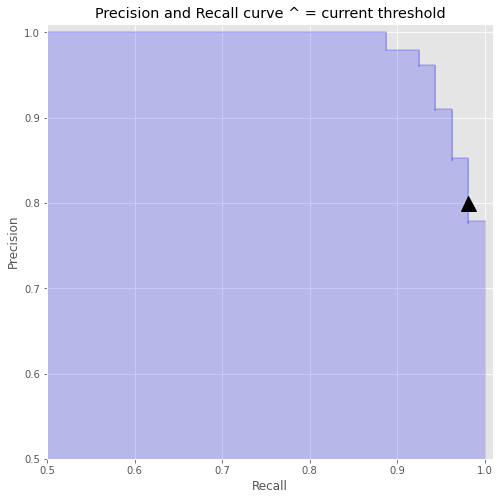

In [25]:
precision_recall_threshold(p, r, thresholds, 0.15)

Finally, the ROC curve shows that to achieve a 1.0 recall, the user of the model must select an operating point that allows for some false positive rate > 0.0.

In [31]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')